In [189]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn.feature_selection import RFE
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from pactools.grid_search import GridSearchCVProgressBar

from sklearn.metrics import accuracy_score, classification_report

# classification models
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

pd.set_option('max_colwidth', 1000)

In [98]:
train = 'clean_train.csv'

In [183]:
df = pd.read_csv(train)
df.drop(labels='Unnamed: 0',axis = 1,inplace = True)


In [184]:
X = df[['year', 'month', 'day', 'Tavg','Latitude', 'Longitude',
       'DewPoint', 'WetBulb', 'PrecipTotal', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Code', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX',
       'day_of_week_Mon', 'day_of_week_Thu', 'day_of_week_Tue',
       'day_of_week_Wed']]

In [193]:
X=df[rem_features]

In [194]:
y = df['WnvPresent']

In [101]:
#'Latitude', 'Longitude'

In [191]:

rfe = RFE(estimator=ExtraTreesClassifier(),n_features_to_select=15)
rfe.fit(X,y)
rfe.transform(X)
rfe_mask = rfe.support_
rem_features = X.columns[rfe_mask]
rem_features = list(rem_features)


In [192]:
rem_features

['year',
 'month',
 'day',
 'Tavg',
 'Latitude',
 'Longitude',
 'DewPoint',
 'WetBulb',
 'PrecipTotal',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Species_CULEX PIPIENS',
 'Species_CULEX PIPIENS/RESTUANS',
 'Species_CULEX RESTUANS']

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=27,stratify=y)

In [196]:
y.value_counts(normalize=True)

0.0    0.947554
1.0    0.052446
Name: WnvPresent, dtype: float64

In [197]:
sm = SMOTETomek(random_state=27, sampling_strategy = 'all', ratio = 0.5)

In [198]:
X_res, y_res = sm.fit_resample(X_train, y_train)

In [199]:
print(X_res.shape)
print(y_res.shape)

(10957, 15)
(10957,)


In [200]:
def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCVProgressBar(model, model_params, cv = 5, n_jobs = -1)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                             'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
        
    return summary_df

In [201]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(random_state = 42),
    'KNN': KNeighborsClassifier(), 
    'NaiveBayes' : MultinomialNB(),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
    'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
    'RandomForest' : RandomForestClassifier(random_state = 42), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 42), 
    'AdaBoost' : AdaBoostClassifier(random_state=42), 
    'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
    'SVM' : SVC(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42)
}

In [202]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1'],
        'C' : np.arange(.05, 1, .05) },
    'KNN' : {
        'n_neighbors' : np.arange(3, 22, 2) },
    'NaiveBayes' : {
        'alpha' : np.arange(.05, 2, .05)},
    'DecisionTree': {
        'max_depth' : [None, 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 60, 100] },
    'RandomForest' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 60, 100, 500],
        'max_depth' : [2, 4, 6, 10, 14],
        'min_samples_leaf' : [1, 2,3 ,4], 
        'min_samples_split' : [2, 3, 4,5,6, 7], },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.05, 1, 20) },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 150, 10),
        'learning_rate' : np.linspace(0.5, 1, 7),
        'max_depth' : [3] },
    'SVM' : {
        'C' : np.arange(0.05, 1, .05),
        'kernel' : ['rbf', 'linear'] },
    'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .3),
        'max_depth' : [3],
        'alpha' : np.arange(0, 1, .3),
        'lambda' : np.arange(0, 1, .3),
        'gamma' : np.arange(0, 1, .3),
        'subsample' : [.5],
        'n_jobs' : [4]
        }
}

In [203]:
gs_summaries = pd.DataFrame()

In [204]:
t0 = time.time()

for model in ['ExtraTrees']:
    gs_summaries = gs_summaries.append(
                        gridsearch_summary(
                            X_res, X_test, y_res, y_test,
                            model, 
                            classifier_models[model], 
                            classifier_model_params['ExtraTrees']), 
                            ignore_index = True)
time.time() - t0

Fitting ExtraTrees


218.25223398208618

In [205]:
gs_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']].T

,0
Model Name,ExtraTrees
Best Params,"{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}"
Best Score,0.901707
Train Score,0.923793
Test Score,0.87362


In [206]:
et = ExtraTreesClassifier(min_samples_leaf= 1, min_samples_split = 2, max_depth = 14, n_estimators = 100)

In [207]:
et.fit(X_res, y_res)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=14, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [208]:
y_pred = et.predict(X_test)

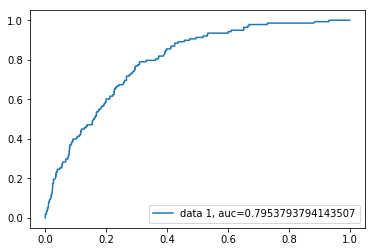

In [209]:
y_pred_proba = et.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [210]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2489
         1.0       0.19      0.40      0.25       138

   micro avg       0.88      0.88      0.88      2627
   macro avg       0.58      0.65      0.59      2627
weighted avg       0.92      0.88      0.90      2627



In [60]:
#2nd run Smote ratio = 0.9
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2489
         1.0       0.20      0.27      0.23       138

   micro avg       0.90      0.90      0.90      2627
   macro avg       0.58      0.60      0.59      2627
weighted avg       0.92      0.90      0.91      2627



In [46]:
#first run
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      2489
         1.0       0.19      0.27      0.22       138

   micro avg       0.90      0.90      0.90      2627
   macro avg       0.57      0.60      0.59      2627
weighted avg       0.92      0.90      0.91      2627



In [39]:
#new run